<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Working with Watson Machine Learning

This notebook should be run using with **Python 3.x with Spark** runtime environment. **If you are viewing this in Watson Studio and do not see Python 3.x with Spark in the upper right corner of your screen, please update the runtime now.** It requires service credentials for the following services:
  * Watson OpenScale
  * Watson Machine Learning
  * DB2
  
The notebook will train, create and deploy a German Credit Risk model, configure OpenScale to monitor that deployment, and inject seven days' worth of historical records and measurements for viewing in the OpenScale Insights dashboard.

### Contents

- [Setup](#setup)
- [Model building and deployment](#model)
- [OpenScale configuration](#openscale)
- [Quality monitor and feedback logging](#quality)
- [Fairness, drift monitoring and explanations](#fairness)
- [Custom monitors and metrics](#custom)
- [Payload analytics](#analytics)
- [Historical data](#historical)

# Setup <a name="setup"></a>

## Package installation

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!rm -rf /home/spark/shared/user-libs/python3.6*

!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
!pip install --upgrade watson-machine-learning-client-V4 | tail -n 1
!pip install --upgrade numpy --no-cache | tail -n 1
!pip install --upgrade SciPy --no-cache | tail -n 1
!pip install lime --no-cache | tail -n 1
!pip install pixiedust | tail -n 1

Requirement already up-to-date: numpy in /Users/dorotadydo-rozniecka/anaconda3/lib/python3.7/site-packages (1.17.3)


### Action: restart the kernel!

Check the Version of PySpark. PySpark 2.3 is required.  

In [3]:
!pip show pyspark 

Name: pyspark
Version: 2.3.0
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /Users/dorotadydo-rozniecka/anaconda3/lib/python3.7/site-packages
Requires: py4j
Required-by: 


## Configure credentials

- WOS_CREDENTIALS (ICP)
- WML_CREDENTIALS (ICP)
- DATABASE_CREDENTIALS (DB2 on ICP)
- SCHEMA_NAME

In [4]:
WOS_CREDENTIALS = {
    "url": "***",
    "username": "***",
    "password": "***"
}

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
WML_CREDENTIALS = WOS_CREDENTIALS.copy()
WML_CREDENTIALS['instance_id']='openshift'
WML_CREDENTIALS['version']='2.5.0'

In [7]:
DATABASE_CREDENTIALS = {
    "jdbcurl": "***",
    "hostname": "***",
    "username": "***",
    "password": "***",
    "port": 50000,
    "db": "***",
    "dsn": "***",
    "uri": "***"
}

In [8]:
# The code was removed by Watson Studio for sharing.

### Action: put created schema name below.

In [9]:
SCHEMA_NAME = 'AIOSFASTPATHICP'

## Run the notebook

At this point, the notebook is ready to run. You can either run the cells one at a time, or click the **Kernel** option above and select **Restart and Run All** to run all the cells.

# Model building and deployment <a name="model"></a>

In this section you will learn how to train Spark MLLib model and next deploy it as web-service using Watson Machine Learning service.

## Load the training data from github

In [11]:
!rm german_credit_data_biased_training.csv
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv

--2019-11-08 13:05:28--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689622 (673K) [text/plain]
Saving to: ‘german_credit_data_biased_training.csv’

german_credit_data_ 100%[===================>] 673.46K   630KB/s    in 1.1s    

2019-11-08 13:05:29 (630 KB/s) - ‘german_credit_data_biased_training.csv’ saved [689622/689622]



In [12]:
import wget
!rm german_credit_data_biased_training.csv
wget.download('https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv')

'german_credit_data_biased_training.csv'

In [13]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
pd_data = pd.read_csv("german_credit_data_biased_training.csv", sep=",", header=0)
df_data = spark.read.csv(path="german_credit_data_biased_training.csv", sep=",", header=True, inferSchema=True)
df_data.head()

Row(CheckingStatus='0_to_200', LoanDuration=31, CreditHistory='credits_paid_to_date', LoanPurpose='other', LoanAmount=1889, ExistingSavings='100_to_500', EmploymentDuration='less_1', InstallmentPercent=3, Sex='female', OthersOnLoan='none', CurrentResidenceDuration=3, OwnsProperty='savings_insurance', Age=32, InstallmentPlans='none', Housing='own', ExistingCreditsCount=1, Job='skilled', Dependents=1, Telephone='none', ForeignWorker='yes', Risk='No Risk')

## Explore data

In [14]:
df_data.printSchema()

root
 |-- CheckingStatus: string (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- CreditHistory: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- ExistingSavings: string (nullable = true)
 |-- EmploymentDuration: string (nullable = true)
 |-- InstallmentPercent: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- OthersOnLoan: string (nullable = true)
 |-- CurrentResidenceDuration: integer (nullable = true)
 |-- OwnsProperty: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- InstallmentPlans: string (nullable = true)
 |-- Housing: string (nullable = true)
 |-- ExistingCreditsCount: integer (nullable = true)
 |-- Job: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Telephone: string (nullable = true)
 |-- ForeignWorker: string (nullable = true)
 |-- Risk: string (nullable = true)



In [15]:
print("Number of records: " + str(df_data.count()))

Number of records: 5000


## Visualize data with pixiedust

In [16]:
import pixiedust

Pixiedust database opened successfully



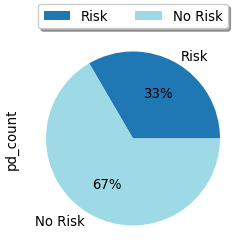

In [ ]:
display(df_data)

## Create a model

In [18]:
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

MODEL_NAME = "Spark German Risk Model - Final"
DEPLOYMENT_NAME = "Spark German Risk Deployment - Final"

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

spark_df.printSchema()

Number of records for training: 4016
Number of records for evaluation: 984
root
 |-- CheckingStatus: string (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- CreditHistory: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- ExistingSavings: string (nullable = true)
 |-- EmploymentDuration: string (nullable = true)
 |-- InstallmentPercent: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- OthersOnLoan: string (nullable = true)
 |-- CurrentResidenceDuration: integer (nullable = true)
 |-- OwnsProperty: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- InstallmentPlans: string (nullable = true)
 |-- Housing: string (nullable = true)
 |-- ExistingCreditsCount: integer (nullable = true)
 |-- Job: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Telephone: string (nullable = true)
 |-- ForeignWorker: string (nullable = true)
 |-- Risk: string (nullable = 

The code below creates a Random Forest Classifier with Spark, setting up string indexers for the categorical features and the label column. Finally, this notebook creates a pipeline including the indexers and the model, and does an initial Area Under ROC evaluation of the model.

In [19]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model

si_CheckingStatus = StringIndexer(inputCol = 'CheckingStatus', outputCol = 'CheckingStatus_IX')
si_CreditHistory = StringIndexer(inputCol = 'CreditHistory', outputCol = 'CreditHistory_IX')
si_LoanPurpose = StringIndexer(inputCol = 'LoanPurpose', outputCol = 'LoanPurpose_IX')
si_ExistingSavings = StringIndexer(inputCol = 'ExistingSavings', outputCol = 'ExistingSavings_IX')
si_EmploymentDuration = StringIndexer(inputCol = 'EmploymentDuration', outputCol = 'EmploymentDuration_IX')
si_Sex = StringIndexer(inputCol = 'Sex', outputCol = 'Sex_IX')
si_OthersOnLoan = StringIndexer(inputCol = 'OthersOnLoan', outputCol = 'OthersOnLoan_IX')
si_OwnsProperty = StringIndexer(inputCol = 'OwnsProperty', outputCol = 'OwnsProperty_IX')
si_InstallmentPlans = StringIndexer(inputCol = 'InstallmentPlans', outputCol = 'InstallmentPlans_IX')
si_Housing = StringIndexer(inputCol = 'Housing', outputCol = 'Housing_IX')
si_Job = StringIndexer(inputCol = 'Job', outputCol = 'Job_IX')
si_Telephone = StringIndexer(inputCol = 'Telephone', outputCol = 'Telephone_IX')
si_ForeignWorker = StringIndexer(inputCol = 'ForeignWorker', outputCol = 'ForeignWorker_IX')

In [20]:
si_Label = StringIndexer(inputCol="Risk", outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_Label.labels)

In [21]:
va_features = VectorAssembler(inputCols=["CheckingStatus_IX", "CreditHistory_IX", "LoanPurpose_IX", "ExistingSavings_IX", "EmploymentDuration_IX", "Sex_IX", \
                                         "OthersOnLoan_IX", "OwnsProperty_IX", "InstallmentPlans_IX", "Housing_IX", "Job_IX", "Telephone_IX", "ForeignWorker_IX", \
                                         "LoanDuration", "LoanAmount", "InstallmentPercent", "CurrentResidenceDuration", "LoanDuration", "Age", "ExistingCreditsCount", \
                                         "Dependents"], outputCol="features")

In [22]:
from pyspark.ml.classification import RandomForestClassifier
classifier = RandomForestClassifier(featuresCol="features")

pipeline = Pipeline(stages=[si_CheckingStatus, si_CreditHistory, si_EmploymentDuration, si_ExistingSavings, si_ForeignWorker, si_Housing, si_InstallmentPlans, si_Job, si_LoanPurpose, si_OthersOnLoan,\
                               si_OwnsProperty, si_Sex, si_Telephone, si_Label, va_features, classifier, label_converter])
model = pipeline.fit(train_data)

In [23]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderROC')
area_under_curve = evaluatorDT.evaluate(predictions)

evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderPR')
area_under_PR = evaluatorDT.evaluate(predictions)
#default evaluation is areaUnderROC
print("areaUnderROC = %g" % area_under_curve, "areaUnderPR = %g" % area_under_PR)

areaUnderROC = 0.704362 areaUnderPR = 0.620377


In [24]:
# extra code: evaluate more metrics by exporting them into pandas and numpy
from sklearn.metrics import classification_report
y_pred = predictions.toPandas()['prediction']
y_pred = ['Risk' if pred == 1.0 else 'No Risk' for pred in y_pred]
y_test = test_data.toPandas()['Risk']
print(classification_report(y_test, y_pred, target_names=['Risk', 'No Risk']))

              precision    recall  f1-score   support

        Risk       0.79      0.90      0.84       657
     No Risk       0.71      0.51      0.60       327

    accuracy                           0.77       984
   macro avg       0.75      0.70      0.72       984
weighted avg       0.76      0.77      0.76       984



## Publish the model

In this section, the notebook uses Watson Machine Learning to save the model (including the pipeline) to the WML instance. Previous versions of the model are removed so that the notebook can be run again, resetting all data for another demo.

In [25]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

# this is a new feature in CP4D, in order to deploy a model, you would have to create different
# deployment spaces and deploy your models there. You can list all the spaces using the .list()
# function, or you can create new spaces by going to CP4D menu on top left corner --> analyze -->
# analytics deployments --> New Deployment Space. Once you know which space you want to deploy
# in, simply use the GUID of the space as argument for .set.default_space() function below
wml_client.spaces.list()
# wml_client.set.default_space('323608a7-21d3-48c8-8c62-dcf4bfe06e17')

/Users/dorotadydo-rozniecka/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


------------------------------------  -------------------  ------------------------
GUID                                  NAME                 CREATED
aac7c473-90a5-40af-b7a6-7d5c2c776754  tutorial-space       2019-11-08T11:24:40.165Z
d42294f6-f114-4b10-a67b-e4c6ec04c21c  auto-test-space      2019-11-08T04:08:35.475Z
7bcb28ac-1b12-4c71-b011-e17703b376eb  openscale-fast-path  2019-11-08T00:35:58.384Z
------------------------------------  -------------------  ------------------------


2019-11-08 13:06:22,901 - matplotlib.font_manager - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


In [26]:
space_name = "tutorial-space"
spaces = wml_client.spaces.get_details()['resources']
space_id = None
for space in spaces:
    if space['entity']['name'] == space_name:
        space_id = space["metadata"]["guid"]
if space_id is None:
    space_id = wml_client.spaces.store(
        meta_props={wml_client.spaces.ConfigurationMetaNames.NAME: space_name})["metadata"]["guid"]
wml_client.set.default_space(space_id)

'SUCCESS'

### Remove existing model and deployment

In [27]:
deployment_details = wml_client.deployments.get_details()
for deployment in deployment_details['resources']:
    deployment_id = deployment['metadata']['guid']
    model_id = deployment['entity']['asset']['href'].split('/')[3].split('?')[0]
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)
wml_client.repository.list_models()

Deleting deployment id 08de0f25-cddd-4a89-8ce0-99333fbb7110
Deleting model id 0b919b8b-d1e4-4267-a511-06db3675bde8
----  ----  -------  ----
GUID  NAME  CREATED  TYPE
----  ----  -------  ----


In [ ]:
db2_credentials = {
            "hostname": "***",
            "password": "***",
            "https_url": "***",
            "port": 50000,
            "ssldsn": "***",
            "host": "***",
            "jdbcurl": "***",
            "uri": "***",
            "db": "***",
            "dsn": "***",
            "username": "***",
            "ssljdbcurl": "***"
        }

In [ ]:
training_data_reference = training_data_reference = {
    "type":"***",
            "name": "***",
            "connection": db2_credentials,
            "location": {
                "tablename": "***",
                "type": "***"
            }
        }

In [28]:
# The code was removed by Watson Studio for sharing.

In [29]:
# The code was removed by Watson Studio for sharing.

In [30]:
wml_models = wml_client.repository.get_model_details()
model_uid = None

for model_in in wml_models['resources']:
    if MODEL_NAME == model_in['entity']['name']:
        model_uid = model_in['metadata']['guid']
        break

if model_uid is None:
    print("Storing model ...")
    metadata = {
        wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
        wml_client.repository.ModelMetaNames.TYPE: 'mllib_2.3',
        wml_client.repository.ModelMetaNames.RUNTIME_UID: 'spark-mllib_2.3',
    }

    published_model_details = wml_client.repository.store_model(model, metadata, training_data=df_data,  pipeline=pipeline)
    model_uid = wml_client.repository.get_model_uid(published_model_details)
    print("Done")

Storing model ...
Done


In [31]:
model_uid

'2ab5138e-d8ba-4b41-bf99-c995d0ad0295'

## Deploy the model

The next section of the notebook deploys the model as a RESTful web service in Watson Machine Learning. The deployed model will have a scoring URL you can use to send data to the model for predictions.

In [32]:
wml_deployments = wml_client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break

if deployment_uid is None:
    print("Deploying model...")
    meta_props = {
        wml_client.deployments.ConfigurationMetaNames.NAME: DEPLOYMENT_NAME,
        wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
    }
    deployment = wml_client.deployments.create(artifact_uid=model_uid, meta_props=meta_props)
    deployment_uid = wml_client.deployments.get_uid(deployment)
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

Deploying model...


#######################################################################################

Synchronous deployment creation for uid: '2ab5138e-d8ba-4b41-bf99-c995d0ad0295' started

#######################################################################################


initializing.
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='0d078a3f-ba3a-4029-a309-632c43654bba'
------------------------------------------------------------------------------------------------


Model id: 2ab5138e-d8ba-4b41-bf99-c995d0ad0295
Deployment id: 0d078a3f-ba3a-4029-a309-632c43654bba


# Configure OpenScale <a name="openscale"></a>

The notebook will now import the necessary libraries and set up a Python OpenScale client.

In [33]:
from ibm_ai_openscale import APIClient4ICP
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *

In [34]:
ai_client = APIClient4ICP(WOS_CREDENTIALS)
ai_client.version

'2.1.17.38'

## Create datamart

### Set up datamart

Watson OpenScale uses a database to store payload logs and calculated metrics. If an OpenScale datamart exists in Db2, the existing datamart will be used and no data will be overwritten.

Prior instances of the German Credit model will be removed from OpenScale monitoring.

In [35]:
try:
    data_mart_details = ai_client.data_mart.get_details()
    print('Using existing external datamart')
except:
    print('Setting up external datamart')
    ai_client.data_mart.setup(db_credentials=DATABASE_CREDENTIALS, schema=SCHEMA_NAME)

Using existing external datamart


In [36]:
data_mart_details = ai_client.data_mart.get_details()

## Bind machine learning engines

Watson OpenScale needs to be bound to the Watson Machine Learning instance to capture payload data into and out of the model. If this binding already exists, this code will output a warning message and use the existing binding.

In [37]:
binding_uid = ai_client.data_mart.bindings.add('WML instance', WatsonMachineLearningInstance4ICP())
if binding_uid is None:
    binding_uid = ai_client.data_mart.bindings.get_details()['service_bindings'][0]['metadata']['guid']
bindings_details = ai_client.data_mart.bindings.get_details()
ai_client.data_mart.bindings.list()

Warning during bind instance.
Status code: 409, body: {"errors":[{"code":"AIQCS0010W","message":"Service Binding with this id is already defined"}],"trace":"N2RkYjUxMzItYmY0MC00YjEzLTk2MTEtMDVlNzM1ZGU2NzMw"}


999,ICP WML Instance,watson_machine_learning,2019-11-08T12:08:20.153Z


In [38]:
print(binding_uid)

999


In [39]:
print(ai_client.data_mart.bindings.list())

999,ICP WML Instance,watson_machine_learning,2019-11-08T12:08:20.153Z


None


In [40]:
ai_client.data_mart.bindings.list_assets()

2ab5138e-d8ba-4b41-bf99-c995d0ad0295,Spark German Risk Model - Final,2019-11-08T12:06:15.002Z,model,mllib_2.3,999,False
ed1ba001-5049-4b58-ad91-4d50710666a3,AutoAI wine prediction model WMLv4fff,2019-11-08T11:55:53.002Z,model,wml-hybrid_0.1,999,False
d8de97e2-5253-4915-a34a-b74102e984c1,GermanCreditRiskModelICP,2019-11-08T11:31:14.002Z,model,mllib_2.3,999,False
4787fb60-2b76-4a64-b3e7-c913b46ca529,AIOS SPSS Customer Model,2019-11-08T11:03:12.002Z,model,spss-modeler_18.1,999,False
a81d9baa-8fa1-4096-a802-369f8a1f91f7,AutoAI video game model WMLv4,2019-11-08T08:19:58.002Z,model,wml-hybrid_0.1,999,False
687c770a-1e4f-4434-8a5a-74c67deba958,AutoAI Car Price model WMLv4,2019-11-08T08:11:28.002Z,model,wml-hybrid_0.1,999,False
746c9eed-3fb7-4ba3-b4f4-067ecfbc8529,AutoAI Customer Churn model WMLv4,2019-11-08T08:11:26.002Z,model,wml-hybrid_0.1,999,False
acc4b3e7-68a7-4188-8176-3cebf95977a2,AutoAI bank marketing model WMLv4,2019-11-08T08:11:25.002Z,model,wml-hybrid_0.1,999,False
406471d2-ae70-4435-8d99-fc84154fa46e,AutoAI Iris model WMLv4,2019-11-08T08:11:23.002Z,model,wml-hybrid_0.1,999,False
ca58e4f3-0569-4116-9a50-ea6fc2bc205e,AutoAI wine prediction model WMLv4,2019-11-08T08:11:21.002Z,model,wml-hybrid_0.1,999,False
7bb27b85-1ad5-456c-a272-b2323c4d7bcf,AutoAI credit risk model WMLv4,2019-11-08T08:11:19.002Z,model,wml-hybrid_0.1,999,False


## Subscriptions

### Remove existing credit risk subscriptions

This code removes previous subscriptions to the German Credit model to refresh the monitors with the new model and new data.

In [111]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = ai_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    if sub_name == MODEL_NAME:
        ai_client.data_mart.subscriptions.delete(subscription)
        print('Deleted existing subscription for', MODEL_NAME)

This code creates the model subscription in OpenScale using the Python client API. Note that we need to provide the model unique identifier, and some information about the model itself.

In [112]:
subscription = ai_client.data_mart.subscriptions.add(WatsonMachineLearningAsset(
    model_uid,
    problem_type=ProblemType.BINARY_CLASSIFICATION,
    input_data_type=InputDataType.STRUCTURED,
    label_column='Risk',
    prediction_column='predictedLabel',
    probability_column='probability',
    feature_columns = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"],
    categorical_columns = ["CheckingStatus","CreditHistory","LoanPurpose","ExistingSavings","EmploymentDuration","Sex","OthersOnLoan","OwnsProperty","InstallmentPlans","Housing","Job","Telephone","ForeignWorker"],
    training_data_reference=training_data_reference
))

if subscription is None:
    print('Subscription already exists; get the existing one')
    subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
    for sub in subscriptions_uids:
        if ai_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
            subscription = ai_client.data_mart.subscriptions.get(sub)

Get subscription list

In [113]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
ai_client.data_mart.subscriptions.list()

fbce8514-a702-41da-a1cc-6aa151e2e480,Spark German Risk Model - Final,model,999,2019-11-08T14:24:30.871Z
1a9d5c88-858b-4f6d-8677-a218f3bf921d,GermanCreditRiskModelICP,model,999,2019-11-08T13:28:56.629Z


In [114]:
subscription_details = subscription.get_details()

### Score the model so we can configure monitors

Now that the WML service has been bound and the subscription has been created, we need to send a request to the model before we configure OpenScale. This allows OpenScale to create a payload log in the datamart with the correct schema, so it can capture data coming into and out of the model. First, the code gets the model deployment's endpoint URL, and then sends a few records for predictions.

In [115]:
credit_risk_scoring_endpoint = None
print(deployment_uid)

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['guid']:
        credit_risk_scoring_endpoint = deployment['entity']['status']['online_url']['url']
        
print(credit_risk_scoring_endpoint)

0d078a3f-ba3a-4029-a309-632c43654bba
https://namespace1-cpd-namespace1.apps.zloct36-lb-1.fyre.ibm.com/v4/deployments/0d078a3f-ba3a-4029-a309-632c43654bba/predictions


In [116]:
fields = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"]
values = [
  ["no_checking",13,"credits_paid_to_date","car_new",1343,"100_to_500","1_to_4",2,"female","none",3,"savings_insurance",46,"none","own",2,"skilled",1,"none","yes"],
  ["no_checking",24,"prior_payments_delayed","furniture",4567,"500_to_1000","1_to_4",4,"male","none",4,"savings_insurance",36,"none","free",2,"management_self-employed",1,"none","yes"],
  ["0_to_200",26,"all_credits_paid_back","car_new",863,"less_100","less_1",2,"female","co-applicant",2,"real_estate",38,"none","own",1,"skilled",1,"none","yes"],
  ["0_to_200",14,"no_credits","car_new",2368,"less_100","1_to_4",3,"female","none",3,"real_estate",29,"none","own",1,"skilled",1,"none","yes"],
  ["0_to_200",4,"no_credits","car_new",250,"less_100","unemployed",2,"female","none",3,"real_estate",23,"none","rent",1,"management_self-employed",1,"none","yes"],
  ["no_checking",17,"credits_paid_to_date","car_new",832,"100_to_500","1_to_4",2,"male","none",2,"real_estate",42,"none","own",1,"skilled",1,"none","yes"],
  ["no_checking",33,"outstanding_credit","appliances",5696,"unknown","greater_7",4,"male","co-applicant",4,"unknown",54,"none","free",2,"skilled",1,"yes","yes"],
  ["0_to_200",13,"prior_payments_delayed","retraining",1375,"100_to_500","4_to_7",3,"male","none",3,"real_estate",37,"none","own",2,"management_self-employed",1,"none","yes"]
]

payload_scoring = {"fields": fields,"values": values}
payload = {
    wml_client.deployments.ScoringMetaNames.INPUT_DATA: [payload_scoring]
}
scoring_response = wml_client.deployments.score(deployment_uid, payload)

print('Single record scoring result:', '\n fields:', scoring_response['predictions'][0]['fields'], '\n values: ', scoring_response['predictions'][0]['values'][0])

Single record scoring result: 
 fields: ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker', 'CheckingStatus_IX', 'CreditHistory_IX', 'EmploymentDuration_IX', 'ExistingSavings_IX', 'ForeignWorker_IX', 'Housing_IX', 'InstallmentPlans_IX', 'Job_IX', 'LoanPurpose_IX', 'OthersOnLoan_IX', 'OwnsProperty_IX', 'Sex_IX', 'Telephone_IX', 'features', 'rawPrediction', 'probability', 'prediction', 'predictedLabel'] 
 values:  ['no_checking', 13, 'credits_paid_to_date', 'car_new', 1343, '100_to_500', '1_to_4', 2, 'female', 'none', 3, 'savings_insurance', 46, 'none', 'own', 2, 'skilled', 1, 'none', 'yes', 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, [21, [1, 3, 5, 13, 14, 15, 16, 17, 18, 19, 20], [1.0, 1.0, 1.0, 13

# Quality monitoring and feedback logging <a name="quality"></a>

## Enable quality monitoring

The code below waits ten seconds to allow the payload logging table to be set up before it begins enabling monitors. First, it turns on the quality (accuracy) monitor and sets an alert threshold of 70%. OpenScale will show an alert on the dashboard if the model accuracy measurement (area under the curve, in the case of a binary classifier) falls below this threshold.

The second paramater supplied, min_records, specifies the minimum number of feedback records OpenScale needs before it calculates a new measurement. The quality monitor runs hourly, but the accuracy reading in the dashboard will not change until an additional 50 feedback records have been added, via the user interface, the Python client, or the supplied feedback endpoint.

In [117]:
time.sleep(10)
subscription.quality_monitoring.enable(threshold=0.7, min_records=50)

## Feedback logging

The code below downloads and stores enough feedback data to meet the minimum threshold so that OpenScale can calculate a new accuracy measurement. It then kicks off the accuracy monitor. The monitors run hourly, or can be initiated via the Python API, the REST API, or the graphical user interface.

In [118]:
!rm additional_feedback_data.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/additional_feedback_data.json

--2019-11-08 15:24:55--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/additional_feedback_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16506 (16K) [text/plain]
Saving to: ‘additional_feedback_data.json’

additional_feedback 100%[===================>]  16.12K  --.-KB/s    in 0.09s   

2019-11-08 15:24:56 (188 KB/s) - ‘additional_feedback_data.json’ saved [16506/16506]



In [119]:
with open('additional_feedback_data.json') as feedback_file:
    additional_feedback_data = json.load(feedback_file)
subscription.feedback_logging.store(additional_feedback_data['data'])

In [120]:
subscription.feedback_logging.show_table()

less_0,10,all_credits_paid_back,car_new,250,500_to_1000,4_to_7,3,male,none,2,real_estate,23,none,rent,1,skilled,1,none,yes,No Risk,2019-11-08 14:24:58.703661+00:00
no_checking,23,prior_payments_delayed,appliances,6964,100_to_500,4_to_7,4,female,none,3,car_other,39,none,own,1,skilled,1,none,yes,Risk,2019-11-08 14:24:58.703930+00:00
0_to_200,30,outstanding_credit,appliances,3464,100_to_500,greater_7,3,male,guarantor,4,savings_insurance,51,stores,free,1,skilled,1,yes,yes,Risk,2019-11-08 14:24:58.703964+00:00
no_checking,23,outstanding_credit,car_used,2681,500_to_1000,greater_7,4,male,none,3,car_other,33,stores,free,1,unskilled,1,yes,yes,No Risk,2019-11-08 14:24:58.703981+00:00
0_to_200,18,prior_payments_delayed,furniture,1673,less_100,1_to_4,2,male,none,3,car_other,30,none,own,2,skilled,1,none,yes,Risk,2019-11-08 14:24:58.703990+00:00
no_checking,44,outstanding_credit,radio_tv,3476,unknown,greater_7,4,male,co-applicant,4,unknown,60,none,free,2,skilled,2,yes,yes,Risk,2019-11-08 14:24:58.703999+00:00
less_0,8,no_credits,education,803,less_100,unemployed,1,male,none,1,savings_insurance,19,stores,rent,1,skilled,1,none,yes,No Risk,2019-11-08 14:24:58.704010+00:00
0_to_200,7,all_credits_paid_back,car_new,250,less_100,unemployed,1,male,none,1,real_estate,19,stores,rent,1,skilled,1,none,yes,No Risk,2019-11-08 14:24:58.704026+00:00
0_to_200,33,credits_paid_to_date,radio_tv,3548,100_to_500,1_to_4,3,male,none,4,car_other,28,none,own,2,skilled,1,yes,yes,Risk,2019-11-08 14:24:58.704041+00:00
no_checking,24,prior_payments_delayed,retraining,4158,100_to_500,greater_7,3,female,none,2,savings_insurance,35,stores,own,1,unskilled,2,none,yes,Risk,2019-11-08 14:24:58.704066+00:00


In [121]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run 15f9103a-a128-4a13-8e7d-c931be115347 




completed

---------------------------
 Successfully finished run 
---------------------------




In [122]:
subscription.quality_monitoring.show_table()

2019-11-08 14:25:07.840000+00:00,true_positive_rate,562275f2-7b58-4166-80f0-c5e3d214c6a0,0.3333333333333333,,,model_type: original,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba
2019-11-08 14:25:07.840000+00:00,area_under_roc,562275f2-7b58-4166-80f0-c5e3d214c6a0,0.6282051282051282,0.7,,model_type: original,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba
2019-11-08 14:25:07.840000+00:00,precision,562275f2-7b58-4166-80f0-c5e3d214c6a0,0.6875,,,model_type: original,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba
2019-11-08 14:25:07.840000+00:00,f1_measure,562275f2-7b58-4166-80f0-c5e3d214c6a0,0.4489795918367347,,,model_type: original,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba
2019-11-08 14:25:07.840000+00:00,accuracy,562275f2-7b58-4166-80f0-c5e3d214c6a0,0.7244897959183674,,,model_type: original,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba
2019-11-08 14:25:07.840000+00:00,log_loss,562275f2-7b58-4166-80f0-c5e3d214c6a0,0.43998295331905485,,,model_type: original,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba
2019-11-08 14:25:07.840000+00:00,false_positive_rate,562275f2-7b58-4166-80f0-c5e3d214c6a0,0.07692307692307693,,,model_type: original,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba
2019-11-08 14:25:07.840000+00:00,area_under_pr,562275f2-7b58-4166-80f0-c5e3d214c6a0,0.5705782312925171,,,model_type: original,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba
2019-11-08 14:25:07.840000+00:00,recall,562275f2-7b58-4166-80f0-c5e3d214c6a0,0.3333333333333333,,,model_type: original,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba


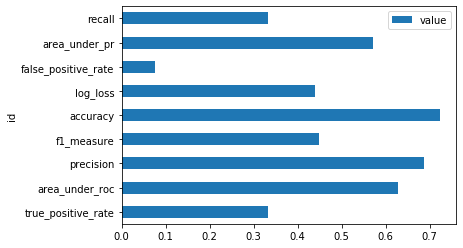

In [123]:
%matplotlib inline

quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd.plot.barh(x='id', y='value');

In [124]:
ai_client.data_mart.get_deployment_metrics()

{'deployment_metrics': [{'asset': {'asset_id': '6b53826d-99ce-4347-b3a2-d67d5775aa09',
    'asset_type': 'model',
    'created_at': '2019-11-08T13:28:32.002Z',
    'name': 'GermanCreditRiskModelICP',
    'url': 'https://ibm-nginx-svc.namespace1.svc.cluster.local/v4/models/6b53826d-99ce-4347-b3a2-d67d5775aa09?space_id=7bcb28ac-1b12-4c71-b011-e17703b376eb'},
   'deployment': {'created_at': '2019-11-08T13:28:37.730Z',
    'deployment_id': 'cfc14eb8-9a25-4533-8320-77a4525764b0',
    'deployment_rn': '',
    'deployment_type': 'online',
    'name': 'GermanCreditRiskModelICP',
    'scoring_endpoint': {'request_headers': {'Content-Type': 'application/json'},
     'url': 'https://ibm-nginx-svc.namespace1.svc.cluster.local/v4/deployments/cfc14eb8-9a25-4533-8320-77a4525764b0/predictions'},
    'url': 'https://ibm-nginx-svc.namespace1.svc.cluster.local/v4/deployments/cfc14eb8-9a25-4533-8320-77a4525764b0'},
   'metrics': [{'issues': 0,
     'metric_type': 'performance',
     'timestamp': '2019-11-

# Fairness, drift monitoring and explanations 
 <a name="fairness"></a>

The code below configures fairness monitoring for our model. It turns on monitoring for two features, Sex and Age. In each case, we must specify:
  * Which model feature to monitor
  * One or more **majority** groups, which are values of that feature that we expect to receive a higher percentage of favorable outcomes
  * One or more **minority** groups, which are values of that feature that we expect to receive a higher percentage of unfavorable outcomes
  * The threshold at which we would like OpenScale to display an alert if the fairness measurement falls below (in this case, 95%)

Additionally, we must specify which outcomes from the model are favourable outcomes, and which are unfavourable. We must also provide the number of records OpenScale will use to calculate the fairness score. In this case, OpenScale's fairness monitor will run hourly, but will not calculate a new fairness rating until at least 200 records have been added. Finally, to calculate fairness, OpenScale must perform some calculations on the training data, so we provide the dataframe containing the data.

In [125]:
subscription.fairness_monitoring.enable(
            features=[
                Feature("Sex", majority=['male'], minority=['female'], threshold=0.95),
                Feature("Age", majority=[[26,75]], minority=[[18,25]], threshold=0.95)
            ],
            favourable_classes=['No Risk'],
            unfavourable_classes=['Risk'],
            min_records=200,
            training_data=pd_data
        )

## Drift configuration

In [127]:
subscription.drift_monitoring.enable(min_records=100, threshold=0.1)

drift_status = None
while drift_status != 'finished':
    drift_details = subscription.drift_monitoring.get_details()
    drift_status = drift_details['parameters']['config_status']['state']
    if drift_status != 'finished':
        print(datetime.datetime.utcnow().strftime('%H:%M:%S'), drift_status)
        time.sleep(30)
print(drift_status)



finished


In [128]:
subscription.get_details()

{'entity': {'asset': {'asset_id': '2ab5138e-d8ba-4b41-bf99-c995d0ad0295',
   'asset_type': 'model',
   'created_at': '2019-11-08T12:06:15.002Z',
   'name': 'Spark German Risk Model - Final',
   'url': 'https://ibm-nginx-svc.namespace1.svc.cluster.local/v4/models/2ab5138e-d8ba-4b41-bf99-c995d0ad0295?space_id=aac7c473-90a5-40af-b7a6-7d5c2c776754'},
  'asset_properties': {'categorical_fields': ['CheckingStatus',
    'CreditHistory',
    'LoanPurpose',
    'ExistingSavings',
    'EmploymentDuration',
    'Sex',
    'OthersOnLoan',
    'OwnsProperty',
    'InstallmentPlans',
    'Housing',
    'Job',
    'Telephone',
    'ForeignWorker'],
   'feature_fields': ['CheckingStatus',
    'LoanDuration',
    'CreditHistory',
    'LoanPurpose',
    'LoanAmount',
    'ExistingSavings',
    'EmploymentDuration',
    'InstallmentPercent',
    'Sex',
    'OthersOnLoan',
    'CurrentResidenceDuration',
    'OwnsProperty',
    'Age',
    'InstallmentPlans',
    'Housing',
    'ExistingCreditsCount',
    

## Score the model again now that monitoring is configured

This next section randomly selects 200 records from the data feed and sends those records to the model for predictions. This is enough to exceed the minimum threshold for records set in the previous section, which allows OpenScale to begin calculating fairness.

In [129]:
!rm german_credit_feed.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_feed.json

--2019-11-08 15:34:53--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_feed.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3076279 (2.9M) [text/plain]
Saving to: ‘german_credit_feed.json’

german_credit_feed. 100%[===================>]   2.93M  1.04MB/s    in 2.8s    

2019-11-08 15:34:57 (1.04 MB/s) - ‘german_credit_feed.json’ saved [3076279/3076279]



Score 200 randomly chosen records

In [130]:
import random

with open('german_credit_feed.json', 'r') as scoring_file:
    scoring_data = json.load(scoring_file)

fields = scoring_data['fields']
values = []
for _ in range(200):
    values.append(random.choice(scoring_data['values']))
payload_scoring = {"fields": fields, "values": values}
payload = {
    wml_client.deployments.ScoringMetaNames.INPUT_DATA: [payload_scoring]
}
scoring_response = wml_client.deployments.score(deployment_uid, payload)

## Run fairness monitor

Kick off a fairness monitor run on current data. The monitor runs hourly, but can be manually initiated using the Python client, the REST API, or the graphical user interface.

In [131]:
time.sleep(5)

run_details = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=0d078a3f-ba3a-4029-a309-632c43654bba 




RUNNING.......
FINISHED

---------------------------
 Successfully finished run 
---------------------------




In [132]:
time.sleep(5)

subscription.fairness_monitoring.show_table()

2019-11-08 14:35:08.602869+00:00,Sex,female,True,0.944,75.5,999,fbce8514-a702-41da-a1cc-6aa151e2e480,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba,
2019-11-08 14:35:08.602869+00:00,Age,"[18, 25]",False,1.077,84.0,999,fbce8514-a702-41da-a1cc-6aa151e2e480,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba,


## Run drift monitor

Kick off a drift monitor run on current data. The monitor runs every hour, but can be manually initiated using the Python client, the REST API.

In [133]:
drift_run_details = subscription.drift_monitoring.run(background_mode=False)




 Waiting for end of drift monitoring run  




RUNNING.
COMPLETED

---------------------------
 Successfully finished run 
---------------------------




In [134]:
subscription.drift_monitoring.get_table_content()

,ts,id,measurement_id,value,lower limit,upper limit,tags,binding_id,subscription_id,deployment_id
0,2019-11-08 14:37:39.980854+00:00,data_drift_magnitude,aa3faed1-8a50-45b2-88f1-fd8914c0a26c,0.075,,,,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba
1,2019-11-08 14:37:39.980854+00:00,drift_magnitude,aa3faed1-8a50-45b2-88f1-fd8914c0a26c,0.006,,0.1,,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba
2,2019-11-08 14:37:39.980854+00:00,predicted_accuracy,aa3faed1-8a50-45b2-88f1-fd8914c0a26c,0.766,,,,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba


## Configure Explainability

Finally, we provide OpenScale with the training data to enable and configure the explainability features.

In [135]:
from ibm_ai_openscale.supporting_classes import *
subscription.explainability.enable(training_data=pd_data)

In [136]:
explainability_details = subscription.explainability.get_details()

## Run explanation for sample record

In [137]:
transaction_id = subscription.payload_logging.get_table_content(limit=1)['scoring_id'].values[0]

print(transaction_id)

c2b9aa96-764d-40c0-b824-361c9014d29a-1


In [138]:
explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False)




 Looking for explanation for c2b9aa96-764d-40c0-b824-361c9014d29a-1 




in_progress..................
finished

---------------------------
 Successfully finished run 
---------------------------




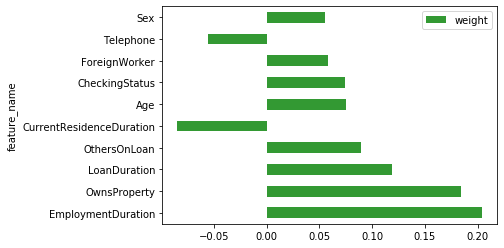

In [139]:
if explain_run == None:
    # explanation didn't finish within 180 seconds, if explaination is still not finished give it a minute or so then re-run this cell
    time.sleep(10)
    explain_table = subscription.explainability.get_table_content(format='pandas')
    explain_result = pd.DataFrame.from_dict(explain_table[explain_table['transaction_id']==transaction_id]['explanation'][0]['entity']['predictions'][0]['explanation_features'])
else:
    explain_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])

explain_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);

# Custom monitors and metrics <a name="custom"></a>

## Register custom monitor

In [140]:
def get_definition(monitor_name):
    monitors_definitions = ai_client.data_mart.monitors.get_details()['monitor_definitions']
    
    for definition in monitors_definitions:
        if monitor_name == definition['entity']['name']:
            return definition
    
    return None

In [141]:
from ibm_ai_openscale.supporting_classes import Metric, Tag

monitor_name = 'my model performance'
metrics = [Metric(name='sensitivity', lower_limit_default=0.8), Metric(name='specificity', lower_limit_default=0.75)]
tags = [Tag(name='region', description='customer geographical region')]

existing_definition = get_definition(monitor_name)

if existing_definition is None:
    my_monitor = ai_client.data_mart.monitors.add(name=monitor_name, metrics=metrics, tags=tags)
else:
    my_monitor = existing_definition

### List monitors

### Get monitors uids and details

In [142]:
monitor_uid = my_monitor['metadata']['guid']

print(monitor_uid)

my_model_performance


In [143]:
my_monitor = ai_client.data_mart.monitors.get_details(monitor_uid=monitor_uid)
print('monitor definition details', my_monitor)

monitor definition details {'entity': {'metrics': [{'expected_direction': 'increasing', 'id': 'sensitivity', 'name': 'sensitivity', 'required': True, 'thresholds': [{'default': 0.8, 'type': 'lower_limit'}]}, {'expected_direction': 'increasing', 'id': 'specificity', 'name': 'specificity', 'required': True, 'thresholds': [{'default': 0.75, 'type': 'lower_limit'}]}], 'name': 'my model performance', 'tags': [{'description': 'customer geographical region', 'id': 'region', 'name': 'region', 'required': True}]}, 'metadata': {'guid': 'my_model_performance', 'url': '/v1/data_marts/00000000-0000-0000-0000-000000000000/monitor_definitions/my_model_performance', 'created_at': '2019-11-08T14:40:15.314Z'}}


## Enable custom monitor for subscription

In [144]:
from ibm_ai_openscale.supporting_classes import Threshold

thresholds = [Threshold(metric_uid='sensitivity', lower_limit=0.9)]
subscription.monitoring.enable(monitor_uid=monitor_uid, thresholds=thresholds)

### Get monitor configuration details

In [145]:
subscription.monitoring.get_details(monitor_uid=monitor_uid)

{'enabled': True,
 'monitor_definition': {'entity': {'metrics': [{'expected_direction': 'increasing',
     'id': 'sensitivity',
     'name': 'sensitivity',
     'required': True,
     'thresholds': [{'default': 0.9, 'type': 'lower_limit'}]},
    {'expected_direction': 'increasing',
     'id': 'specificity',
     'name': 'specificity',
     'required': True}],
   'name': 'my model performance',
   'tags': [{'description': 'customer geographical region',
     'id': 'region',
     'name': 'region',
     'required': True}]},
  'metadata': {'guid': 'my_model_performance',
   'url': '/v1/data_marts/00000000-0000-0000-0000-000000000000/monitor_definitions/my_model_performance',
   'created_at': '2019-11-08T14:40:15.314Z'}},
 'thresholds': [{'metric_id': 'sensitivity',
   'type': 'lower_limit',
   'value': 0.9}]}

## Storing custom metrics

In [146]:
metrics = {"specificity": 0.78, "sensitivity": 0.67, "region": "us-south"}

subscription.monitoring.store_metrics(monitor_uid=monitor_uid, metrics=metrics)

[{'asset_id': '2ab5138e-d8ba-4b41-bf99-c995d0ad0295',
  'binding_id': '999',
  'measurement_id': '272b7f93-b547-4c45-aa57-aefab4e4f04e',
  'metrics': [{'region': 'us-south',
    'sensitivity': 0.67,
    'specificity': 0.78}],
  'monitor_definition_id': 'my_model_performance',
  'subscription_id': 'fbce8514-a702-41da-a1cc-6aa151e2e480',
  'timestamp': '2019-11-08T14:40:17.062890Z'}]

### List and get custom metrics

In [147]:
subscription.monitoring.show_table(monitor_uid=monitor_uid)

2019-11-08 14:40:17.062890+00:00,sensitivity,272b7f93-b547-4c45-aa57-aefab4e4f04e,0.67,0.9,,region: us-south,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba
2019-11-08 14:40:17.062890+00:00,specificity,272b7f93-b547-4c45-aa57-aefab4e4f04e,0.78,,,region: us-south,999,fbce8514-a702-41da-a1cc-6aa151e2e480,0d078a3f-ba3a-4029-a309-632c43654bba


In [148]:
custom_metrics = subscription.monitoring.get_metrics(monitor_uid=monitor_uid, deployment_uid='credit')
custom_metrics

[{'asset_id': '2ab5138e-d8ba-4b41-bf99-c995d0ad0295',
  'binding_id': '999',
  'tags': [{'id': 'region', 'value': 'us-south'}],
  'ts': '2019-11-08T14:40:17.062890Z',
  'measurement_id': '272b7f93-b547-4c45-aa57-aefab4e4f04e',
  'monitor_definition_id': 'my_model_performance',
  'subscription_id': 'fbce8514-a702-41da-a1cc-6aa151e2e480',
  'metrics': [{'lower_limit': 0.9, 'id': 'sensitivity', 'value': 0.67},
   {'id': 'specificity', 'value': 0.78}]}]

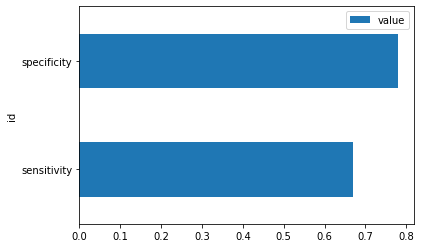

In [149]:
custom_metrics_pandas = subscription.monitoring.get_table_content(monitor_uid=monitor_uid)

%matplotlib inline
custom_metrics_pandas.plot.barh(x='id', y='value');

# Payload analytics <a name="analytics"></a>

## Run data distributions calculation

In [150]:
from datetime import datetime

start_date = "2018-01-01T00:00:00.00Z"
end_date = datetime.utcnow().isoformat() + "Z"

sex_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['predictedLabel', 'Sex'],
            agg=['count'])




 Waiting for end of data distribution run 0c0c10c9-a215-4b08-bed6-abdba0986eeb 




running............
completed

---------------------------
 Successfully finished run 
---------------------------




## Get data distributions as pandas dataframe

In [151]:
sex_distribution_run_uid = sex_distribution['id']
distributions_pd = subscription.payload_logging.data_distribution.get_run_result(run_id=sex_distribution_run_uid, format='pandas')
distributions_pd

,predictedLabel,Sex,count
0,No Risk,female,81
1,No Risk,male,83
2,Risk,female,4
3,Risk,male,40


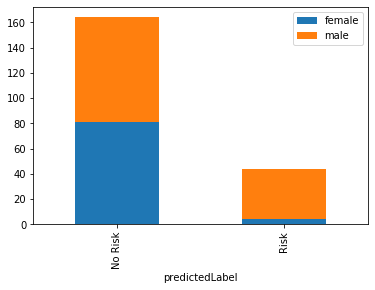

In [152]:
subscription.payload_logging.data_distribution.show_chart(sex_distribution_run_uid);

In [153]:
credit_history_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['predictedLabel', 'CreditHistory'],
            agg=['count'])




 Waiting for end of data distribution run 607c2785-d850-4b62-a236-13889a65bdae 




running...
completed

---------------------------
 Successfully finished run 
---------------------------




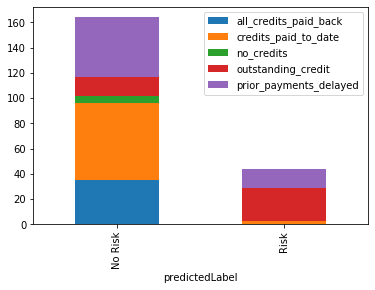

In [154]:
credit_history_distribution_run_uid = credit_history_distribution['id']

subscription.payload_logging.data_distribution.show_chart(credit_history_distribution_run_uid);

# Historical data <a name="historical"></a>

 ## Insert historical payloads

The next section of the notebook downloads and writes historical data to the payload and measurement tables to simulate a production model that has been monitored and receiving regular traffic for the last seven days. This historical data can be viewed in the Watson OpenScale user interface. The code uses the Python and REST APIs to write this data.

In [155]:
!rm history_payloads*.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_0.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_1.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_2.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_3.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_4.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_5.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_6.json

--2019-11-08 15:42:11--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_0.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5018899 (4.8M) [text/plain]
Saving to: ‘history_payloads_0.json’

history_payloads_0. 100%[===================>]   4.79M  1.48MB/s    in 3.2s    

2019-11-08 15:42:15 (1.48 MB/s) - ‘history_payloads_0.json’ saved [5018899/5018899]

--2019-11-08 15:42:15--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP re

In [156]:
historyDays = 7

In [157]:
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
import datetime
import time

for day in range(historyDays):
    print('Loading day {}'.format(day + 1))
    history_file = 'history_payloads_' + str(day) + '.json'
    with open(history_file) as f:
        payloads = json.load(f)
        hourly_records = int(len(payloads) / 24)
        index = 0
        for hour in range(24):
            recordsList = []
            for i in range(hourly_records):
                score_time = str(datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1))))
                recordsList.append(PayloadRecord(request=payloads[index]['request'], response=payloads[index]['response'], scoring_timestamp=score_time))
                index += 1
            subscription.payload_logging.store(records=recordsList)
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


In [158]:
data_mart_id = subscription.get_details()['metadata']['url'].split('/service_bindings')[0].split('marts/')[1]
print(data_mart_id)

00000000-0000-0000-0000-000000000000


In [159]:
performance_metrics_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/metrics'
print(performance_metrics_url)

https://namespace1-cpd-namespace1.apps.zloct36-lb-1.fyre.ibm.com/v1/data_marts/00000000-0000-0000-0000-000000000000/metrics


## Insert historical fairness metrics

In [160]:
!rm history_fairness.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_fairness.json

--2019-11-08 15:45:54--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_fairness.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1424078 (1.4M) [text/plain]
Saving to: ‘history_fairness.json’

history_fairness.js 100%[===================>]   1.36M   655KB/s    in 2.1s    

2019-11-08 15:45:57 (655 KB/s) - ‘history_fairness.json’ saved [1424078/1424078]



In [161]:
from requests.auth import HTTPBasicAuth

def create_token():
    header = {
                    "Content-Type": "application/x-www-form-urlencoded",
                    "Accept": "application/json"
    }

    response = requests_session.get(
            WOS_CREDENTIALS['url'] + '/v1/preauth/validateAuth',
            headers=header,
            auth=HTTPBasicAuth(
                WOS_CREDENTIALS['username'],
                WOS_CREDENTIALS['password']
            ),
            verify=False)

    response = handle_response(200, 'access token', response, True)
    token = response['accessToken']

    return token

In [162]:
iam_token = create_token()
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

with open('history_fairness.json', 'r') as history_file:
    payloads = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        index = (day * 24 + hour) % len(payloads) # wrap around and reuse values if needed
        
        qualityMetric = {
            'metric_type': 'fairness',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': payloads[index]
        }

        response = requests.post(performance_metrics_url, json=[qualityMetric], headers=iam_headers, verify=False)

print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical debias metrics

In [163]:
!rm history_debias.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_debias.json

--2019-11-08 15:49:53--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_debias.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565971 (553K) [text/plain]
Saving to: ‘history_debias.json’

history_debias.json 100%[===================>] 552.71K   460KB/s    in 1.2s    

2019-11-08 15:49:55 (460 KB/s) - ‘history_debias.json’ saved [565971/565971]



In [164]:
iam_token = create_token()
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

with open('history_debias.json', 'r') as history_file:
    payloads = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        index = (day * 24 + hour) % len(payloads) # wrap around and reuse values if needed

        qualityMetric = {
            'metric_type': 'debiased_fairness',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': payloads[index]
        }

        response = requests.post(performance_metrics_url, json=[qualityMetric], headers=iam_headers, verify=False)
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical quality metrics

In [165]:
iam_token = create_token()
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

measurements = [0.76, 0.78, 0.68, 0.72, 0.73, 0.77, 0.80]
for day in range(historyDays):
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        qualityMetric = {
            'metric_type': 'quality',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'quality': measurements[day],
                'threshold': 0.7,
                'metrics': [
                    {
                        'name': 'auroc',
                        'value': measurements[day],
                        'threshold': 0.7
                    }
                ]
            }
        }

        response = requests.post(performance_metrics_url, json=[qualityMetric], headers=iam_headers, verify=False)
print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical confusion matrixes

In [166]:
!rm history_quality_metrics.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_quality_metrics.json

--2019-11-08 15:55:50--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_quality_metrics.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80099 (78K) [text/plain]
Saving to: ‘history_quality_metrics.json’

history_quality_met 100%[===================>]  78.22K   170KB/s    in 0.5s    

2019-11-08 15:55:51 (170 KB/s) - ‘history_quality_metrics.json’ saved [80099/80099]



In [167]:
measurements_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/measurements'
print(measurements_url)

https://namespace1-cpd-namespace1.apps.zloct36-lb-1.fyre.ibm.com/v1/data_marts/00000000-0000-0000-0000-000000000000/measurements


In [168]:
with open('history_quality_metrics.json') as json_file:
    records = json.load(json_file)

for day in range(historyDays):
    index = 0
    measurments = []
    print('Day', day + 1)
    
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')

        measurement = {
            "monitor_definition_id": 'quality',
            "binding_id": subscription.binding_uid,
            "subscription_id": subscription.uid,
            "asset_id": subscription.source_uid,
            'metrics': [records[index]['metrics']],
            'sources': [records[index]['sources']],
            'timestamp': score_time
        }

        measurments.append(measurement)
        index+=1

    response = requests.post(measurements_url, json=measurments, headers=ai_client._get_headers(), verify=False)

print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical performance metrics

In [169]:
iam_token = create_token()
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

for day in range(historyDays):
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        score_count = random.randint(60, 600)
        score_resp = random.uniform(60, 300)

        performanceMetric = {
            'metric_type': 'performance',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'response_time': score_resp,
                'records': score_count
            }
        }

        response = requests.post(performance_metrics_url, json=[performanceMetric], headers=iam_headers, verify=False)
print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical manual labeling

In [170]:
manual_labeling_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/manual_labelings'
print(manual_labeling_url)

https://namespace1-cpd-namespace1.apps.zloct36-lb-1.fyre.ibm.com/v1/data_marts/00000000-0000-0000-0000-000000000000/manual_labelings


In [171]:
!rm history_manual_labeling.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_manual_labeling.json

rm: history_manual_labeling.json: No such file or directory
--2019-11-08 15:59:05--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_manual_labeling.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 947956 (926K) [text/plain]
Saving to: ‘history_manual_labeling.json’

history_manual_labe 100%[===================>] 925.74K   620KB/s    in 1.5s    

2019-11-08 15:59:07 (620 KB/s) - ‘history_manual_labeling.json’ saved [947956/947956]



In [172]:
iam_token = create_token()
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

with open('history_manual_labeling.json', 'r') as history_file:
    records = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    record_json = []
    for hour in range(24):
        for record in records:
            if record['fastpath_history_day'] == day and record['fastpath_history_hour'] == hour:
                record['binding_id'] = binding_uid
                record['subscription_id'] = model_uid
                record['asset_revision'] = model_uid
                record['deployment_id'] = deployment_uid
                record['scoring_timestamp'] = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
                record_json.append(record)
    response = requests.post(manual_labeling_url, json=record_json, headers=iam_headers, verify=False)

print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Additional data to help debugging

In [175]:
print('Datamart:', data_mart_id)
print('Model:', model_uid)
print('Deployment:', deployment_uid)
print('Binding:', binding_uid)
# print('Scoring URL:', credit_risk_scoring_endpoint)

Datamart: 00000000-0000-0000-0000-000000000000
Model: 2ab5138e-d8ba-4b41-bf99-c995d0ad0295
Deployment: 0d078a3f-ba3a-4029-a309-632c43654bba
Binding: 999


## Identify transactions for Explainability

Transaction IDs identified by the cells below can be copied and pasted into the Explainability tab of the OpenScale dashboard.

In [174]:
payload_data = subscription.payload_logging.get_table_content(limit=60)
payload_data.filter(items=['scoring_id', 'predictedLabel', 'probability'])

,scoring_id,predictedLabel,probability
0,c2b9aa96-764d-40c0-b824-361c9014d29a-1,No Risk,"[0.8000401470855272, 0.1999598529144728]"
1,c2b9aa96-764d-40c0-b824-361c9014d29a-2,No Risk,"[0.6959323712566339, 0.304067628743366]"
2,c2b9aa96-764d-40c0-b824-361c9014d29a-3,Risk,"[0.47798261426398553, 0.5220173857360144]"
3,c2b9aa96-764d-40c0-b824-361c9014d29a-4,No Risk,"[0.8694529553919186, 0.13054704460808136]"
4,c2b9aa96-764d-40c0-b824-361c9014d29a-5,No Risk,"[0.7001034077150486, 0.2998965922849513]"
5,c2b9aa96-764d-40c0-b824-361c9014d29a-6,No Risk,"[0.7870501076815899, 0.21294989231841002]"
6,c2b9aa96-764d-40c0-b824-361c9014d29a-7,No Risk,"[0.9610702249396212, 0.03892977506037873]"
7,c2b9aa96-764d-40c0-b824-361c9014d29a-8,No Risk,"[0.7876706014833662, 0.21232939851663374]"
8,c2b9aa96-764d-40c0-b824-361c9014d29a-9,No Risk,"[0.5357589128686531, 0.46424108713134693]"
9,c2b9aa96-764d-40c0-b824-361c9014d29a-10,No Risk,"[0.7017626331953175, 0.2982373668046825]"


## Congratulations!

You have finished the hands-on lab for IBM Watson OpenScale. You can now view the [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). Click on the tile for the German Credit model to see fairness, accuracy, and performance monitors. Click on the timeseries graph to get detailed information on transactions during a specific time window.


## Authors

Eric Martens, is a technical specialist having expertise in analysis and description of business processes, and their translation into functional and non-functional IT requirements. He acts as the interpreter between the worlds of IT and business.

Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Zilu (Peter) Tang, is a cognitive developer with experties in deep learning and enterprise AI solutions from Watson Openscale to many other cutting-edge IBM research projects.